In [1]:
# First import a bunch of useful stuff

import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pickle

from plotter import *

In [2]:
# This gives the integrated luminosity (the amount of data collected) for each year
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

In [3]:
# This dictionary gives the cross section (expected rate) of each simulated process
# Number of events of process P = integrated luminosity * cross section of process P
with open('xsec.json') as f:
  xs = json.load(f)
print(xs)

{'QCD_HT500to700_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 32200, 'QCD_HT700to1000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 6839, 'QCD_HT1000to1500_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 1207, 'QCD_HT1500to2000_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 120.1, 'QCD_HT2000toInf_TuneCUETP8M1_13TeV-madgraphMLM-pythia8': 25.24, 'QCD_HT300to500_TuneCP5_13TeV-madgraph-pythia8': 322600, 'QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8': 29980, 'QCD_HT700to1000_TuneCP5_13TeV-madgraph-pythia8': 6334, 'QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8': 1088, 'QCD_HT1500to2000_TuneCP5_13TeV-madgraph-pythia8': 99.11, 'QCD_HT2000toInf_TuneCP5_13TeV-madgraph-pythia8': 20.23, 'QCD_HT300to500_TuneCP5_13TeV-madgraphMLM-pythia8': 322600, 'QCD_HT500to700_TuneCP5_13TeV-madgraphMLM-pythia8': 29980, 'QCD_HT700to1000_TuneCP5_13TeV-madgraphMLM-pythia8': 6334, 'QCD_HT1000to1500_TuneCP5_13TeV-madgraphMLM-pythia8': 1088, 'QCD_HT1500to2000_TuneCP5_13TeV-madgraphMLM-pythia8': 99.11, 'QCD_HT2000toInf_TuneCP5_13TeV-madg

In [4]:
# This dictionary tells us how to group the simulated samples together sensibly
# For example, QCD is generated separately for different energies. Combine them
with open('pmap_mc.json') as f:
  pmap = json.load(f)
print(pmap)

{'ZH': ['ZH_HToBB_ZToQQ_M125_13TeV_powheg_pythia8', 'ZH_HToBB_ZToNuNu_M125_13TeV_powheg_pythia8', 'ZH_HToBB_ZToLL_M125_13TeV_powheg_pythia8', 'ggZH_HToBB_ZToQQ_M125_13TeV_powheg_pythia8', 'ggZH_HToBB_ZToNuNu_M125_13TeV_powheg_pythia8', 'ggZH_HToBB_ZToLL_M125_13TeV_powheg_pythia8,'], 'WH': ['WminusH_HToBB_WToLNu_M125_13TeV_powheg_pythia8', 'WminusH_HToBB_WToQQ_M125_13TeV_powheg_pythia8', 'WplusH_HToBB_WToLNu_M125_13TeV_powheg_pythia8', 'WplusH_HToBB_WToQQ_M125_13TeV_powheg_pythia8'], 'ttH': ['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'], 'VBF': ['VBFHToBB_M-125_13TeV_powheg_pythia8_weightfix'], 'ggF': ['GluGluHToBB_M-125_13TeV_powheg_MINLO_NNLOPS_pythia8'], 'ggF-powheg': ['GluGluHToBB_M125_TuneCP5_13TeV-powheg-pythia8', 'GluGluHToBB_M125_13TeV_powheg_pythia8'], 'QCD': ['QCD_HT300to500_TuneCP5_13TeV-madgraph-pythia8', 'QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8', 'QCD_HT700to1000_TuneCP5_13TeV-madgraph-pythia8', 'QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8', 'QCD_HT1500to2000_TuneC

In [5]:
# I like to run this for one year at a time
year = '2017'
outsum = processor.dict_accumulator()

In [6]:
# Higgs mass window
mbb_min = 110
mbb_max = 138

In [7]:
# Number-counting significance as a function of the number of signal (s) and background (b) events
def significance(s,b):
    if b==0:
        return 0
    z_squared = 2.0*(s+b)*np.log(1.0+1.0*s/b) - 2.0*s
    return np.sqrt(z_squared)

In [8]:
# The quickest option here: copy the pickle file from my area:
# /uscms/home/jennetd/nobackup/hbb-prod-modes/march-2021/vbf-ddbopt/pickles/templates.pkl

# To save time, I run the "load all files" step below once and pickle templates
# Then read in one histogram instead of loading all files each time
# First time I run with repickle=True. Else run with repickle=False
repickle=True

# Check if pickle exists, and don't re-create it if it does
picklename = 'pickles/templates.pkl'
if os.path.isfile(picklename):
    repickle=False

In [9]:
# Load all files - this takes a while
if repickle:
    nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
    for n in range(1,nfiles+1):

        with open('infiles-split/'+year+'_'+str(n)+'.json') as f:
            infiles = json.load(f)
        
        # Skip data - we are dealing with only simulation right now
        if 'JetHT' in infiles.keys():
            continue
        if 'SingleMuon' in infiles.keys():
            continue
    
        #filename = '/myeosdir/vbf-ddbopt/outfiles/'+year+'_'+str(n)+'.coffea'
        filename = 'outfiles/'+year+'_'+str(n)+'.coffea'
        if os.path.isfile(filename):
            out = util.load(filename)
            outsum.add(out)
            print('Loaded file '+str(n))
        else:
            print('Missing file '+str(n),infiles.keys())
            #print("File " + filename + " is missing")
        
    scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
    outsum['templates1'].scale(scale_lumi, 'dataset')
    
    # Use pmap to group the datasets together
    templates = outsum['templates1'].group('dataset', hist.Cat('process', 'Process'), pmap)
    
    # Select out the signal region
    templates = templates.integrate('region', 'signal')

    outfile = open(picklename, 'wb')
    pickle.dump(templates, outfile, protocol=-1)
    outfile.close()

Loaded file 1
Missing file 2 dict_keys(['DYJetsToLL_M-50_HT-1200to2500_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 3 dict_keys(['DYJetsToLL_M-50_HT-1200to2500_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 4 dict_keys(['DYJetsToLL_M-50_HT-1200to2500_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 5 dict_keys(['DYJetsToLL_M-50_HT-2500toInf_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 6 dict_keys(['DYJetsToLL_M-50_HT-2500toInf_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 7 dict_keys(['DYJetsToLL_M-50_HT-2500toInf_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 8 dict_keys(['DYJetsToLL_M-50_HT-400to600_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 9 dict_keys(['DYJetsToLL_M-50_HT-400to600_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 10 dict_keys(['DYJetsToLL_M-50_HT-400to600_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 11 dict_keys(['DYJetsToLL_M-50_HT-400to600_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 12 dict_keys(['DYJetsToLL_M-50_HT-400to600

Missing file 471 dict_keys(['QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 472 dict_keys(['QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 473 dict_keys(['QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 474 dict_keys(['QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 475 dict_keys(['QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 476 dict_keys(['QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 477 dict_keys(['QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 478 dict_keys(['QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 479 dict_keys(['QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 480 dict_keys(['QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 481 dict_keys(['QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 482 dict_keys(['QCD_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 483 dict_keys(['QCD_HT1000t

Missing file 721 dict_keys(['QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 722 dict_keys(['QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 723 dict_keys(['QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 724 dict_keys(['QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 725 dict_keys(['QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 726 dict_keys(['QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 727 dict_keys(['QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 728 dict_keys(['QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 729 dict_keys(['QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 730 dict_keys(['QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 731 dict_keys(['QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 732 dict_keys(['QCD_HT500to700_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 733 dict_keys(['QCD_HT500to700_TuneCP5_13TeV-madgra

Missing file 963 dict_keys(['QCD_HT700to1000_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 964 dict_keys(['QCD_HT700to1000_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 965 dict_keys(['QCD_HT700to1000_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 966 dict_keys(['QCD_HT700to1000_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 967 dict_keys(['QCD_HT700to1000_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 968 dict_keys(['QCD_HT700to1000_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 969 dict_keys(['QCD_HT700to1000_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 970 dict_keys(['QCD_HT700to1000_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 971 dict_keys(['QCD_HT700to1000_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 972 dict_keys(['QCD_HT700to1000_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 973 dict_keys(['QCD_HT700to1000_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 974 dict_keys(['QCD_HT700to1000_TuneCP5_13TeV-madgraph-pythia8'])
Missing file 975 dict_keys(['QCD_HT700to1000_TuneCP5

Missing file 1557 dict_keys(['TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1558 dict_keys(['TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1559 dict_keys(['TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1560 dict_keys(['TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1561 dict_keys(['TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1562 dict_keys(['TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1563 dict_keys(['TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1564 dict_keys(['TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1565 dict_keys(['TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1566 dict_keys(['TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1567 dict_keys(['TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1568 dict_keys(['TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1569 dict_keys(['TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1570 dict_keys(['TTTo2L2Nu_TuneCP5_13TeV-powheg-pyt

Missing file 1873 dict_keys(['TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1874 dict_keys(['TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1875 dict_keys(['TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1876 dict_keys(['TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1877 dict_keys(['TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1878 dict_keys(['TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1879 dict_keys(['TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1880 dict_keys(['TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1881 dict_keys(['TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1882 dict_keys(['TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1883 dict_keys(['TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1884 dict_keys(['TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8'])
Missing file 1885 dict_keys(['TTToSemiLeptonic_TuneC

Missing file 2185 dict_keys(['WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 2186 dict_keys(['WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 2187 dict_keys(['WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 2188 dict_keys(['WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 2189 dict_keys(['WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 2190 dict_keys(['WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 2191 dict_keys(['WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 2192 dict_keys(['WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 2193 dict_keys(['WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 2194 dict_keys(['WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 2195 dict_keys(['WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8'])

Missing file 2497 dict_keys(['WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 2498 dict_keys(['WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 2499 dict_keys(['WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 2500 dict_keys(['WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 2501 dict_keys(['WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 2502 dict_keys(['WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 2503 dict_keys(['WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 2504 dict_keys(['WJetsToQQ_HT-800toInf_qc19_3j_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 2505 dict_keys(['WJetsToQQ_HT-800toInf_qc19_3j_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 2506 dict_keys(['WJetsToQQ_HT-800toInf_qc19_3j_TuneCP5_13TeV-madgraphMLM-pythia8'])
Missing file 2507 dict_keys(['WJetsToQQ_HT-800toInf_qc19_3j_TuneCP5_13Te

Missing file 2804 dict_keys(['ggZH_HToBB_ZToQQ_M125_13TeV_powheg_pythia8'])
Missing file 2805 dict_keys(['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'])
Missing file 2806 dict_keys(['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'])
Missing file 2807 dict_keys(['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'])
Missing file 2808 dict_keys(['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'])
Missing file 2809 dict_keys(['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'])
Missing file 2810 dict_keys(['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'])
Missing file 2811 dict_keys(['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'])
Missing file 2812 dict_keys(['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'])
Missing file 2813 dict_keys(['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'])
Missing file 2814 dict_keys(['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'])
Missing file 2815 dict_keys(['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'])
Missing file 2816 dict_keys(['ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8'])
Missing file 2817 dict_k

/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:376: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f9d18bb76d0>
  warnings.warn(


In [10]:
# Read the histogram from the pickle file
templates = pickle.load(open(picklename,'rb'))

In [11]:
# Sum over all bins and print the total number of events per process
templates.sum('msd1','deta','mjj','ddb1').values()

{('Zjets',): 118.16692228880802}

In [12]:
# Sum the histogram over all but one variable
x = templates.sum('deta','mjj','ddb1')

KeyError: ()

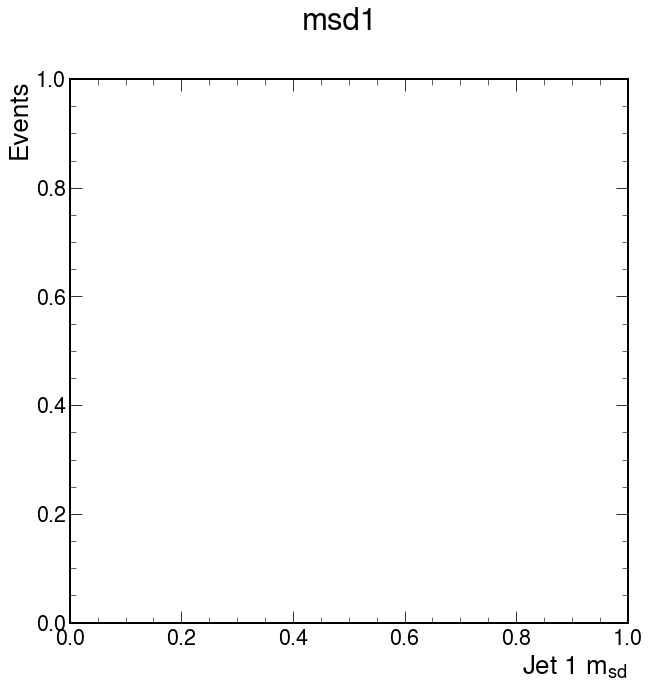

In [13]:
# draw the plot of soft drop mass
# NB: the Higgs mass window is 110-138 GeV
plot_mconly_vbf(x,'msd1','msd1')

In [14]:
# Select out events in the Higgs mass window
templates_window=templates.integrate('msd1',int_range=slice(mbb_min,mbb_max))

In [15]:
# Apply a cut
templates_cut = templates_window.integrate('deta',int_range=slice(3.5,7)).integrate('mjj',int_range=slice(1000,4000))

# Print the number of events passing the cut per process
templates_cut.sum('ddb1').values()

{('Zjets',): 0.5888819044388561}

In [16]:
sr = templates_cut.sum().values()

# Get the number of signal and background events
s = sr[('VBF',)] 
b = sr[('QCD',)] + sr[('Zjets',)] + sr[('Wjets',)] + sr[('VV',)] + sr[('ttbar',)] +sr[('singlet',)] + sr[('ggF',)] + sr[('WH',)] + sr[('ZH',)] + sr[('ttH',)]

# Print the significance
print(significance(s,b))
# Note: this only makes sense in the mass window of Higgs

KeyError: ('VBF',)